<a href="https://colab.research.google.com/github/v-enigma/DL_LabExperiments/blob/main/Lab_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9316 - loss: 0.1487
Epoch 15/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9327 - loss: 0.1472
Epoch 16/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9320 - loss: 0.1467
Epoch 17/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9320 - loss: 0.1459
Epoch 18/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9324 - loss: 0.1449
Epoch 19/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9319 - loss: 0.1439
Epoch 20/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9308 - loss: 0.1438

Training model without batch normalization:
Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7999 - loss: 0.4779
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9516 - loss: 0.1411
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9653 - loss: 0.0973
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9668 - loss: 0.0910
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━

<ipython-input-2-a981244247e6>:169: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()



Training completed and plots saved.

Model with Batch Normalization final loss: 0.13511042296886444
Model without Batch Normalization final loss: 0.030988797545433044


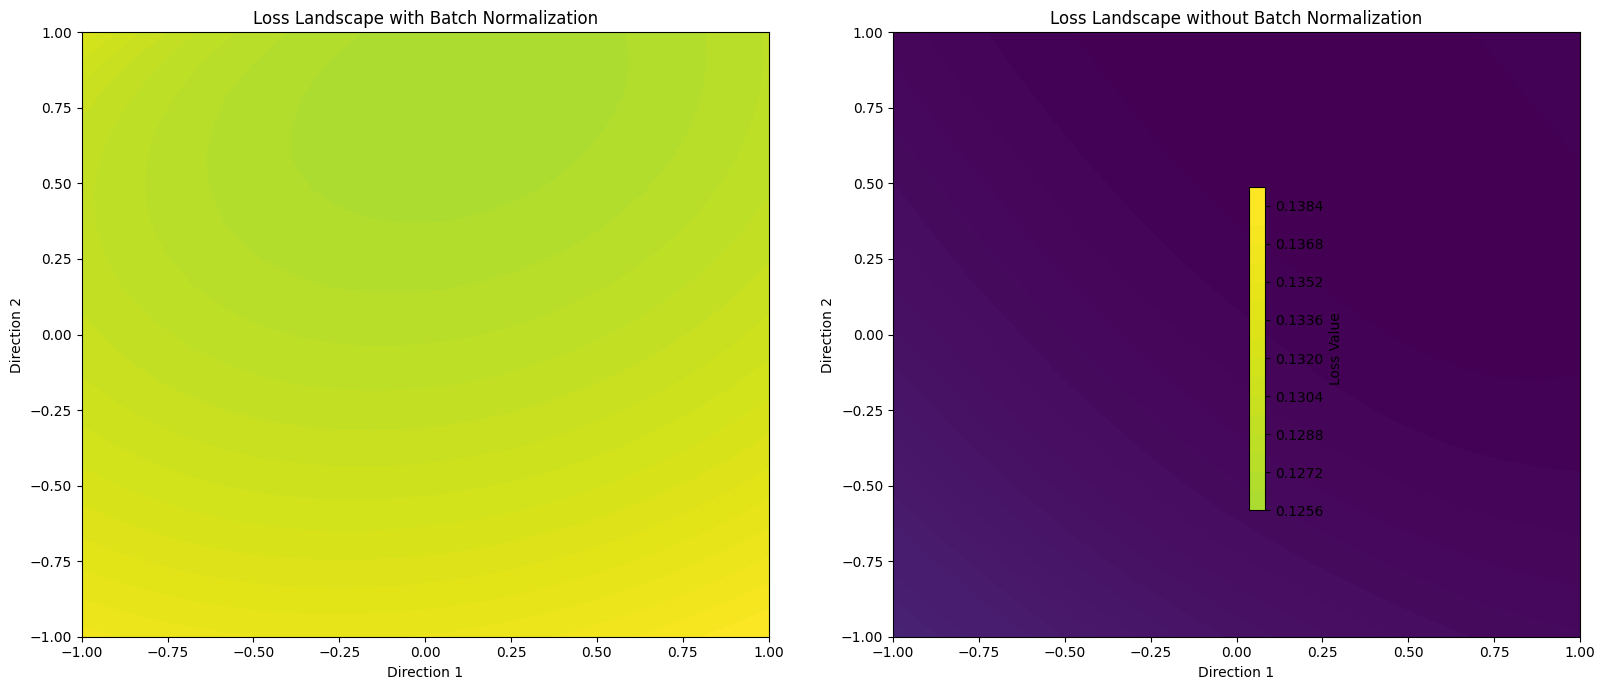

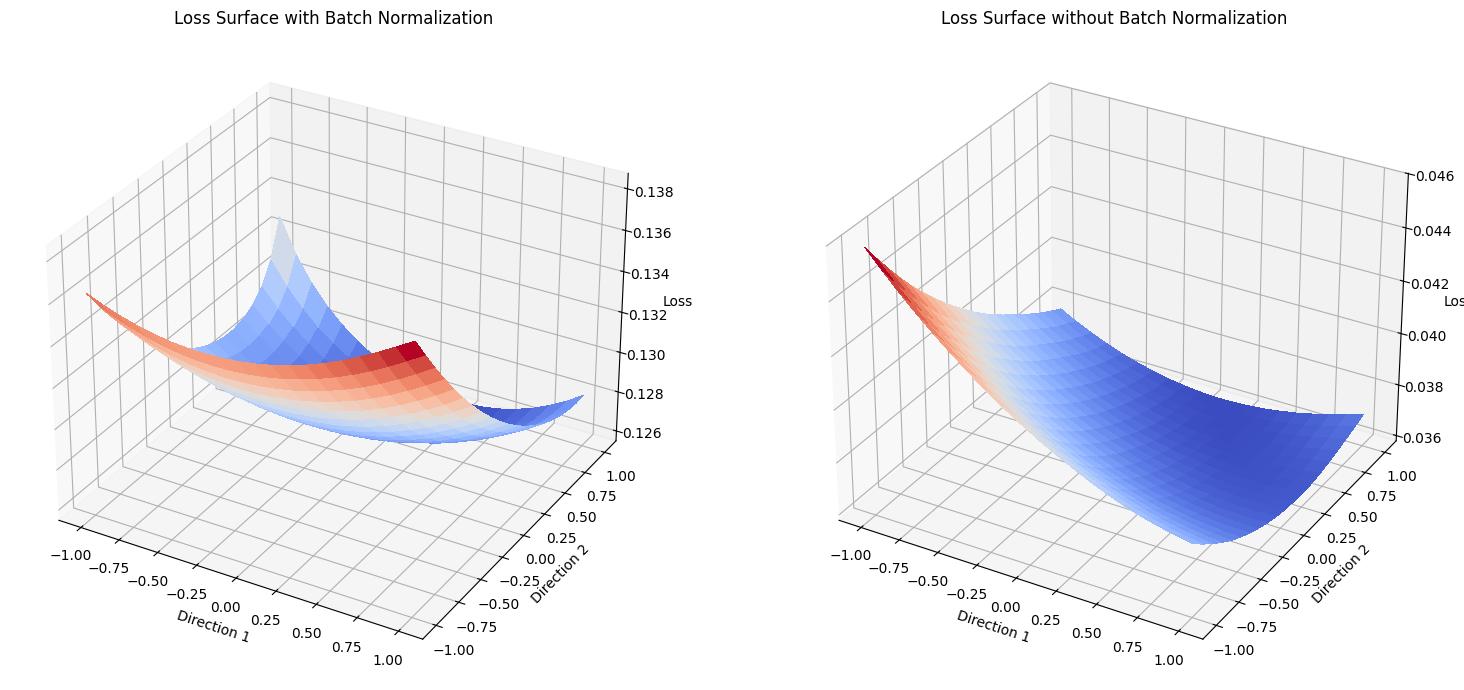

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import cm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Create a synthetic dataset for binary classification
def generate_data(n_samples=1000):
    X = np.random.randn(n_samples, 2)
    # Create a non-linear decision boundary
    y = (np.sin(X[:, 0]) + np.cos(X[:, 1]) > 0).astype(np.float32)
    return X.astype(np.float32), y.reshape(-1, 1)

# Custom callback to store loss history and weights
class LossHistoryCallback(Callback):
    def __init__(self):
        super().__init__()
        self.loss_history = []
        self.initial_weights = None

    def on_train_begin(self, logs=None):
        self.initial_weights = [layer.get_weights() for layer in self.model.layers if layer.weights]

    def on_epoch_end(self, epoch, logs=None):
        self.loss_history.append(logs.get('loss'))

# Define the neural network with batch normalization
def create_model_with_bn(input_size=2, hidden_size=64, output_size=1):
    model = Sequential([
        Dense(hidden_size, input_shape=(input_size,)),
        BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        Dense(hidden_size),
        BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        Dense(output_size, activation='sigmoid')
    ])
    return model

# Define the neural network without batch normalization
def create_model_without_bn(input_size=2, hidden_size=64, output_size=1):
    model = Sequential([
        Dense(hidden_size, input_shape=(input_size,), activation='relu'),
        Dense(hidden_size, activation='relu'),
        Dense(output_size, activation='sigmoid')
    ])
    return model

# Function to compute loss landscape
def compute_loss_landscape(model, X, y, initial_weights, alpha_range=np.linspace(-1, 1, 20), beta_range=np.linspace(-1, 1, 20)):
    # Generate two random directions
    directions = []
    for _ in range(2):
        direction = []
        for layer_weights in initial_weights:
            layer_direction = [np.random.randn(*w.shape) for w in layer_weights]
            direction.append(layer_direction)
        directions.append(direction)

    # Normalize directions
    for d_idx, direction in enumerate(directions):
        flat_direction = np.concatenate([np.ravel(d) for layer_d in direction for d in layer_d])
        norm = np.sqrt(np.sum(flat_direction**2))
        for layer_idx, layer_direction in enumerate(direction):
            for w_idx in range(len(layer_direction)):
                directions[d_idx][layer_idx][w_idx] /= norm

    # Compute loss landscape
    Z = np.zeros((len(alpha_range), len(beta_range)))

    # Save original weights
    original_weights = [layer.get_weights() for layer in model.layers if layer.weights]

    for i, alpha in enumerate(alpha_range):
        for j, beta in enumerate(beta_range):
            # Update model weights: w = w0 + alpha * d1 + beta * d2
            weight_idx = 0
            for layer_idx, layer in enumerate(model.layers):
                if layer.weights:
                    new_weights = []
                    for w_idx, w0 in enumerate(original_weights[weight_idx]):
                        new_w = w0 + alpha * directions[0][weight_idx][w_idx] + beta * directions[1][weight_idx][w_idx]
                        new_weights.append(new_w)
                    layer.set_weights(new_weights)
                    weight_idx += 1

            # Compute loss - Fix: model.evaluate returns a list of [loss, metrics...], so we take the first element
            results = model.evaluate(X, y, verbose=0)
            loss_value = results[0] if isinstance(results, list) else results
            Z[i, j] = loss_value

    # Restore original weights
    weight_idx = 0
    for layer_idx, layer in enumerate(model.layers):
        if layer.weights:
            layer.set_weights(original_weights[weight_idx])
            weight_idx += 1

    return Z, alpha_range, beta_range

# Generate data
X, y = generate_data(2000)

# Create and compile models
model_with_bn = create_model_with_bn()
model_with_bn.compile(optimizer=Adam(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy'])

model_without_bn = create_model_without_bn()
model_without_bn.compile(optimizer=Adam(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy'])

# Create callbacks
history_callback_bn = LossHistoryCallback()
history_callback_without_bn = LossHistoryCallback()

# Train models
print("Training model with batch normalization:")
model_with_bn.fit(X, y, epochs=20, batch_size=64, verbose=1, callbacks=[history_callback_bn])

print("\nTraining model without batch normalization:")
model_without_bn.fit(X, y, epochs=20, batch_size=64, verbose=1, callbacks=[history_callback_without_bn])

# Compute loss landscapes
print("\nComputing loss landscape for model with batch normalization...")
Z_bn, alpha_range, beta_range = compute_loss_landscape(model_with_bn, X, y, history_callback_bn.initial_weights)

print("Computing loss landscape for model without batch normalization...")
Z_without_bn, alpha_range, beta_range = compute_loss_landscape(model_without_bn, X, y, history_callback_without_bn.initial_weights)

# Plot loss histories
plt.figure(figsize=(10, 5))
plt.plot(history_callback_bn.loss_history, label='With Batch Normalization')
plt.plot(history_callback_without_bn.loss_history, label='Without Batch Normalization')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Comparison')
plt.legend()
plt.grid(True)
plt.savefig('loss_history_comparison.png')
plt.close()

# Plot contour plots
fig, axes = plt.subplots(1, 2, figsize=(16, 7))
min_loss = min(Z_bn.min(), Z_without_bn.min())
max_loss = max(Z_bn.max(), Z_without_bn.max())

# Contour plot for model with batch normalization
contour_bn = axes[0].contourf(alpha_range, beta_range, Z_bn, levels=20, cmap='viridis', vmin=min_loss, vmax=max_loss)
axes[0].set_title('Loss Landscape with Batch Normalization')
axes[0].set_xlabel('Direction 1')
axes[0].set_ylabel('Direction 2')

# Contour plot for model without batch normalization
contour_without_bn = axes[1].contourf(alpha_range, beta_range, Z_without_bn, levels=20, cmap='viridis', vmin=min_loss, vmax=max_loss)
axes[1].set_title('Loss Landscape without Batch Normalization')
axes[1].set_xlabel('Direction 1')
axes[1].set_ylabel('Direction 2')

# Add colorbar
cbar = fig.colorbar(contour_bn, ax=axes, shrink=0.6)
cbar.set_label('Loss Value')

plt.tight_layout()
plt.savefig('loss_landscape_comparison.png')

# 3D surface plots for better visualization
fig = plt.figure(figsize=(16, 7))

# 3D plot for model with batch normalization
ax1 = fig.add_subplot(121, projection='3d')
X_grid, Y_grid = np.meshgrid(alpha_range, beta_range)
surf1 = ax1.plot_surface(X_grid, Y_grid, Z_bn, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax1.set_title('Loss Surface with Batch Normalization')
ax1.set_xlabel('Direction 1')
ax1.set_ylabel('Direction 2')
ax1.set_zlabel('Loss')

# 3D plot for model without batch normalization
ax2 = fig.add_subplot(122, projection='3d')
surf2 = ax2.plot_surface(X_grid, Y_grid, Z_without_bn, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax2.set_title('Loss Surface without Batch Normalization')
ax2.set_xlabel('Direction 1')
ax2.set_ylabel('Direction 2')
ax2.set_zlabel('Loss')

plt.tight_layout()
plt.savefig('loss_surface_comparison_3d.png')

# Show the results
print("\nTraining completed and plots saved.")
print("\nModel with Batch Normalization final loss:", history_callback_bn.loss_history[-1])
print("Model without Batch Normalization final loss:", history_callback_without_bn.loss_history[-1])